In [12]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import itertools
import pandas as pd
import torch_geometric as pyg
import numpy as np
import pandas as pd
import torch_geometric as pyg
import torch.nn.functional as F
import hydra
from hydra.core.global_hydra import GlobalHydra
import os
import wandb
import omegaconf
from pathlib import Path
from PIL import Image
os.environ["HYDRA_FULL_ERROR"] = "1"


from mil.data.mnist import MNISTBags, OneHotMNISTBags, MNISTCollage, OneHotMNISTCollage
from mil.utils import device, human_format, set_seed
from mil.utils.visualize import print_one_hot_bag_with_attention, print_one_hot_bag, plot_attention_head, plot_bag, plot_one_hot_collage
from mil.utils.stats import print_prediction_stats
from mil.models.abmil import WeightedAverageAttention
from mil.models.self_attention import MultiHeadSelfAttention
from mil.models.distance_aware_self_attention import DistanceAwareSelfAttentionHead
from mil.utils.layers import find_submodule

WANDB_ENTITY = "georgw7777"
WANDB_PROJECT = "mil"
RUN_ID = "zb2yp78c"
RUN_ID = "w6vh47hn"
RUN_ID = "qriawk5a"
RUN_ID = "vfo4u9wo"

# Load run configuration
api = wandb.Api()
run = api.run(f"{WANDB_ENTITY}/{WANDB_PROJECT}/{RUN_ID}")
cfg = omegaconf.DictConfig(run.config)
cfg.wandb_id = RUN_ID
cfg.seed = cfg.get("seed", 0)

set_seed(cfg.seed)

In [2]:
train_ds = hydra.utils.instantiate(cfg.dataset.train)
test_ds =  hydra.utils.instantiate(cfg.dataset.test)

test_loader = torch.utils.data.DataLoader(test_ds, batch_size=1, shuffle=False, collate_fn=lambda x: x[0], num_workers=0, pin_memory=False)

In [3]:
model = hydra.utils.instantiate(cfg.model, _convert_="partial")
model.load_state_dict(torch.load(Path("checkpoints") / RUN_ID / "model_latest.pt"))
model.eval()

DistanceAwareSelfAttentionHead.SAVE_INTERMEDIATE = True
attention_layer = find_submodule(model, DistanceAwareSelfAttentionHead)

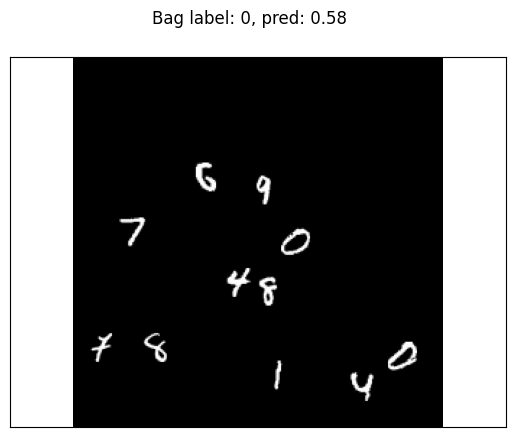

In [26]:
bag = test_ds[75]
y_pred, _ = model(bag)
img = plot_bag(bag, y_pred=y_pred, collage_size=test_ds.collage_size)
Image.fromarray((img*255).astype(np.uint8)).save("mnist_neg.png")

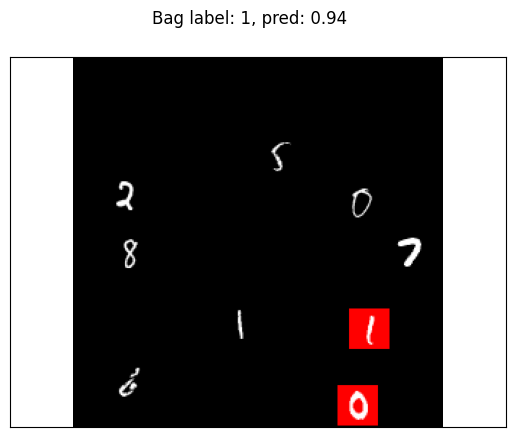

In [27]:
bag = test_ds[46]
y_pred, _ = model(bag)
img = plot_bag(bag, y_pred=y_pred, collage_size=test_ds.collage_size)
Image.fromarray((img*255).astype(np.uint8)).save("mnist_pos.png")

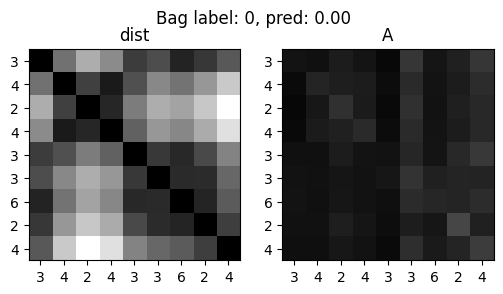

In [5]:
def plot_dist_aware_attention(bag, model, attention_layer):
    y_pred, _ = model(bag)
    plt.figure(figsize=(6, 3))
    plt.suptitle(f"Bag label: {bag.y.item():.0f}, pred: {y_pred.item():.2f}")
    plt.subplot(121)
    plt.title("dist")
    dist = pyg.utils.to_dense_adj(bag.edge_index, edge_attr=bag.edge_attr.squeeze(-1), max_num_nodes=bag.num_nodes).squeeze(0)  # NxN
    plot_attention_head(bag, dist, limit_range=False)
    plt.subplot(122)
    plt.title("A")
    plot_attention_head(bag, attention_layer.A)

plot_dist_aware_attention(bag, model, attention_layer)

In [6]:
from train import test, History

loss_function = hydra.utils.instantiate(cfg.loss)
history = History()

predictions = test(cfg, model, loss_function, test_loader, history, save_predictions=True)
print_prediction_stats(predictions, target_numbers=cfg.settings.mnist.target_numbers)

Testing: 100%|██████████| 100/100 [00:00<00:00, 415.73it/s]



                                 % acc    total    -pred    +pred     example
  bags                              96      100       46       54     6 2 2 4 8 4 4 9 3 9 9 9 0 2
  bags with 0s                      96       78       25       53     6 2 2 4 8 4 4 9 3 9 9 9 0 2
  bags without 0s                   95       22       21        1     5 4 5 8 4 5 4 9 2 3 2 9 7
  bags with 0s and 1s               95       62        9       53     9 1 9 2 0 4 0 7 2 0
  bags with 0s and not 1s          100       16       16        0     6 2 2 4 8 4 4 9 3 9 9 9 0 2
  bags with 1s                      94       78       24       54     9 1 9 2 0 4 0 7 2 0
  bags without 1s                  100       22       22        0     6 2 2 4 8 4 4 9 3 9 9 9 0 2
  bags with 1s and 0s               95       62        9       53     9 1 9 2 0 4 0 7 2 0
  bags with 1s and not 0s           93       16       15        1     1 6 4 8 3 1 5
  bags with 2 key instance(s)      100       39        0       39     3 9 9 3 2

### First 10 bags in test dataset

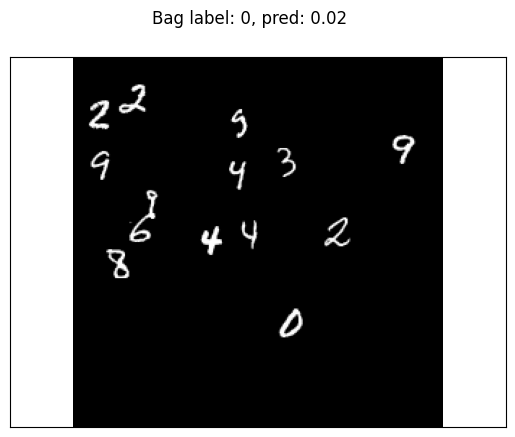

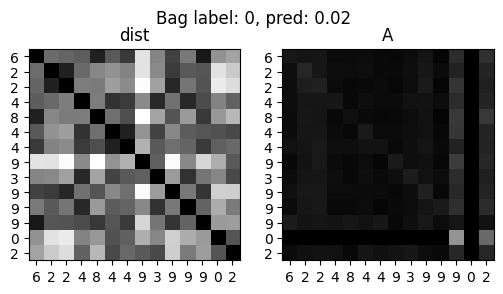

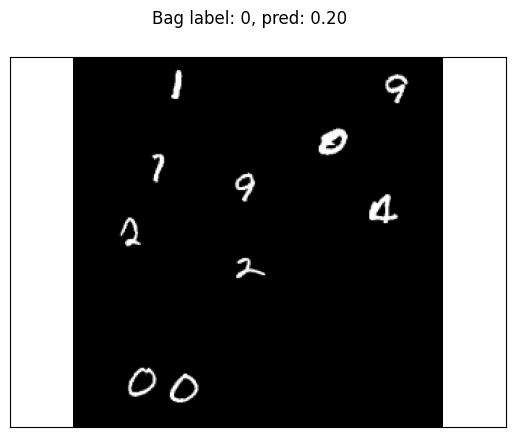

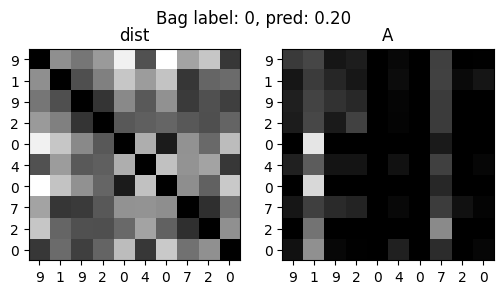

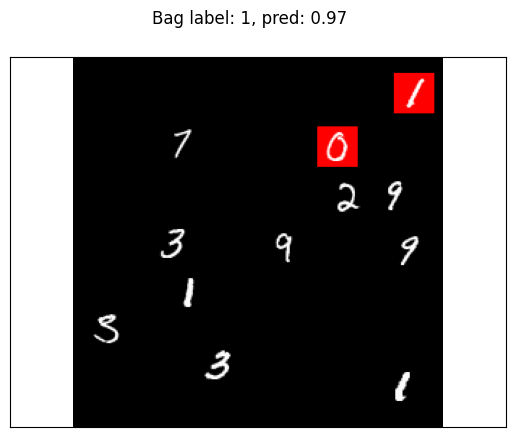

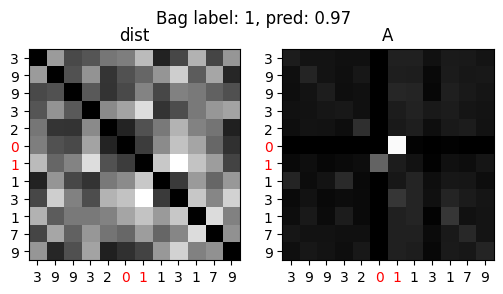

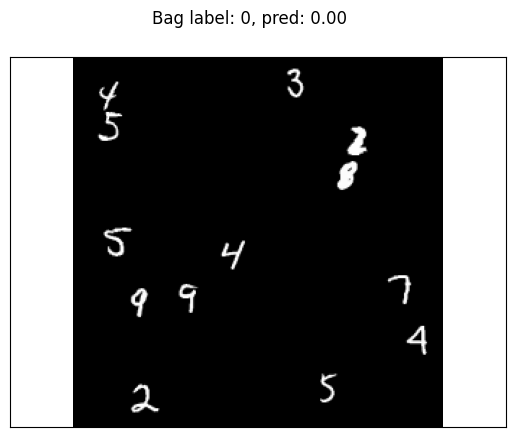

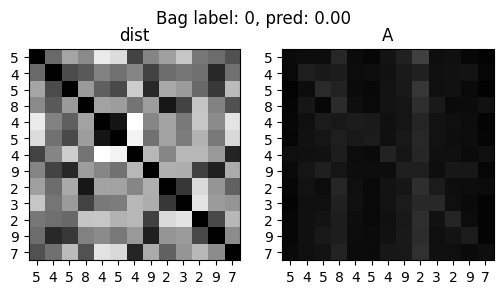

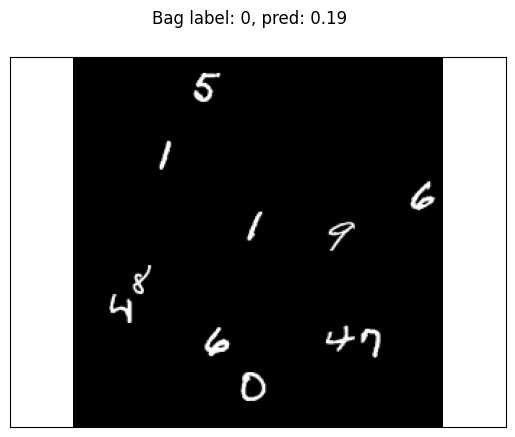

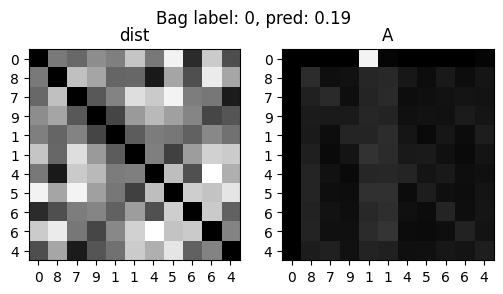

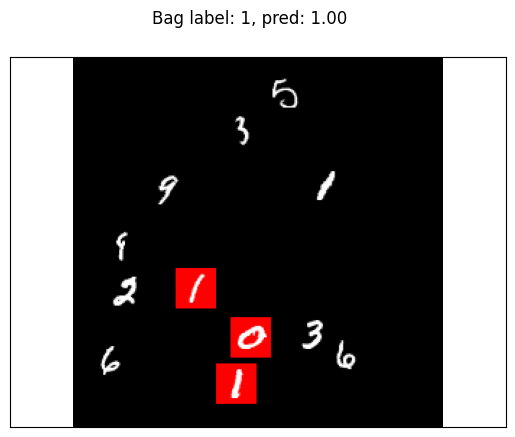

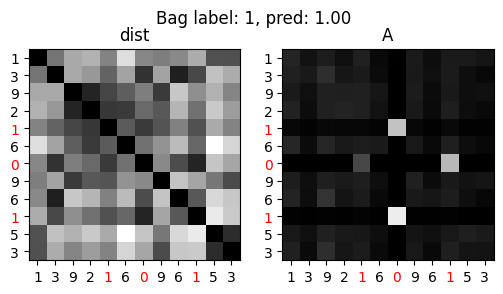

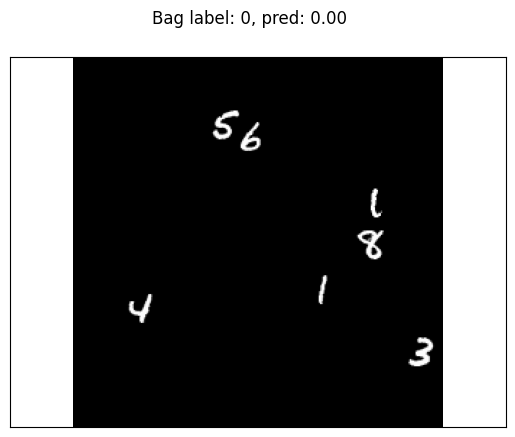

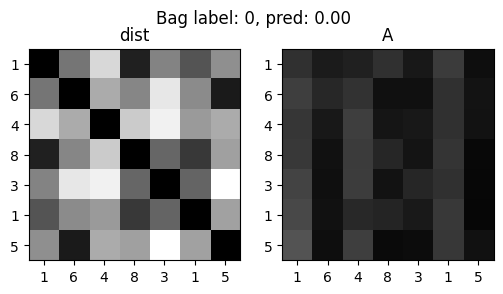

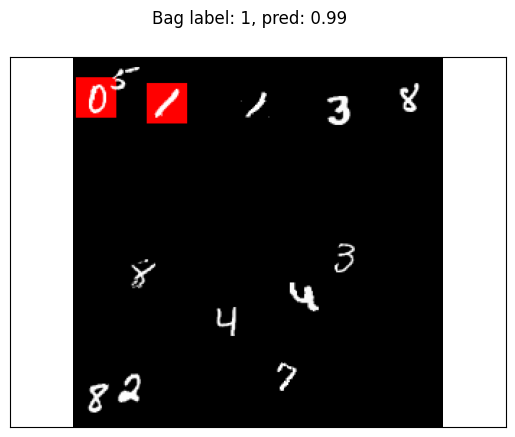

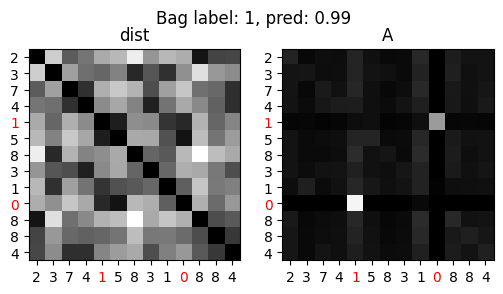

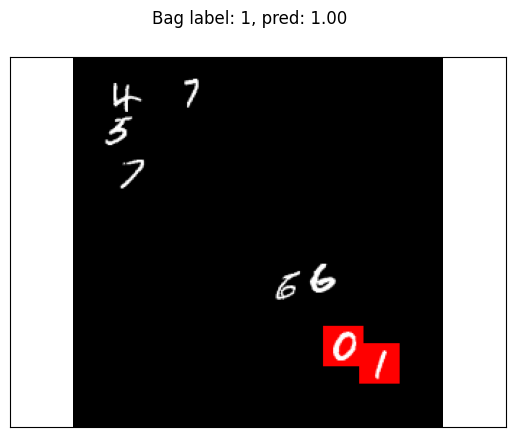

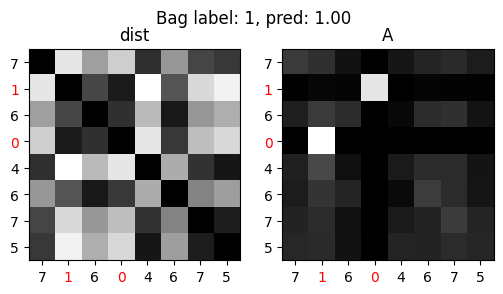

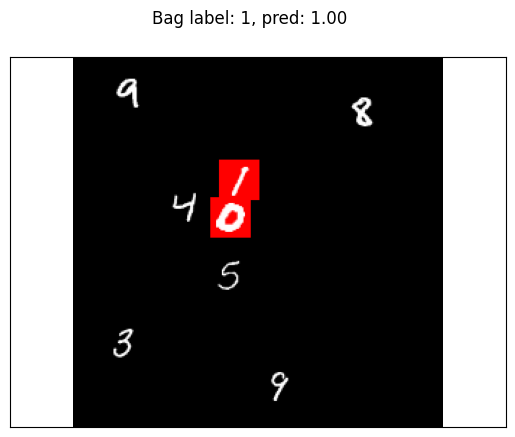

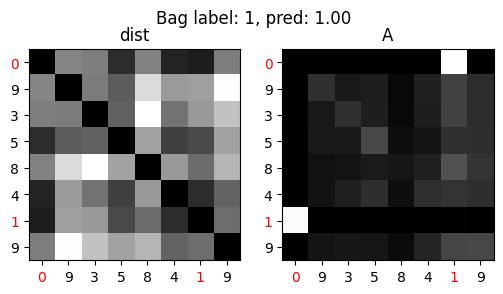

In [7]:
def visualize_prediction(bag, y_pred):
    plot_bag(bag, y_pred=y_pred, collage_size=test_ds.collage_size)
    plot_dist_aware_attention(bag, model, attention_layer)

# Visualize first 10 bags
model.eval()
with torch.no_grad():
    for bag in itertools.islice(test_loader, 10):
        bag = device(bag)
        y = bag.y.float()
        y_pred, _ = model(bag)
        visualize_prediction(bag, y_pred)

### First 10 mistakes in test dataset

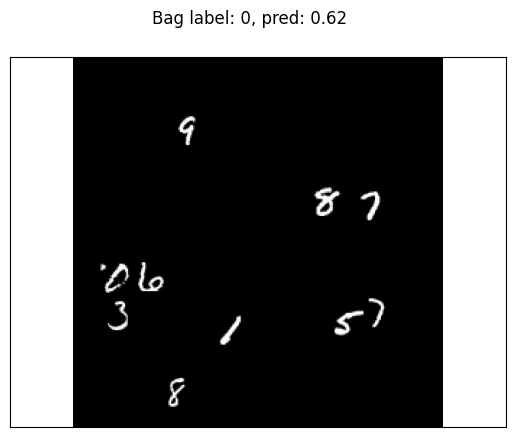

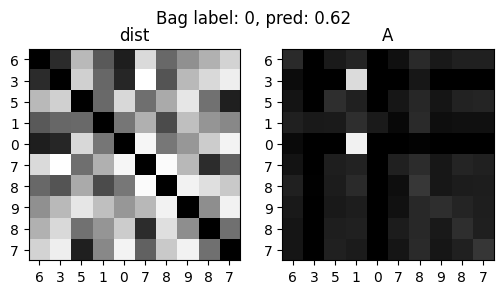

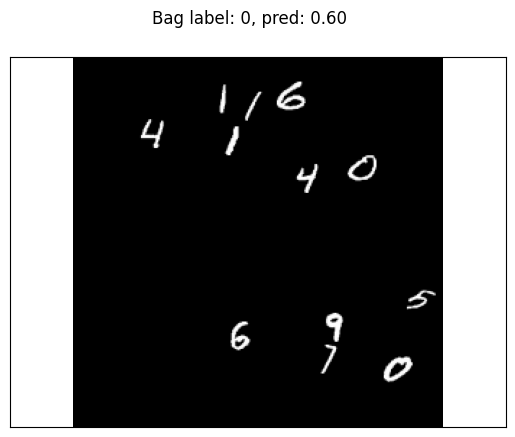

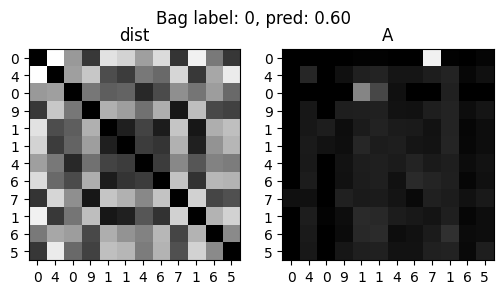

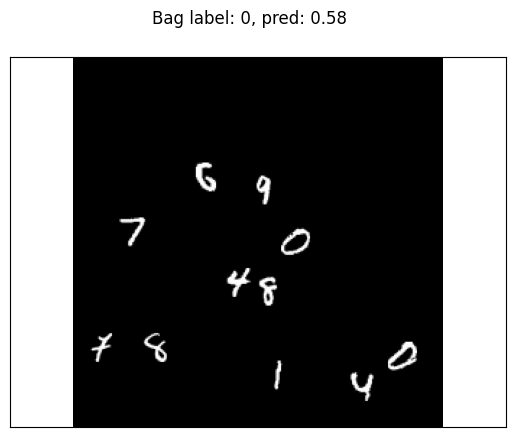

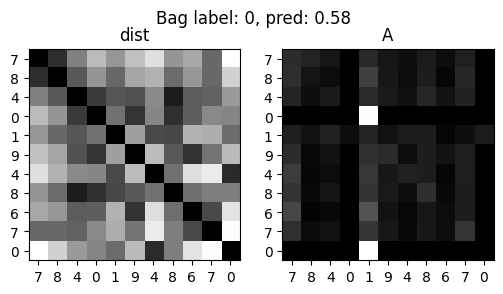

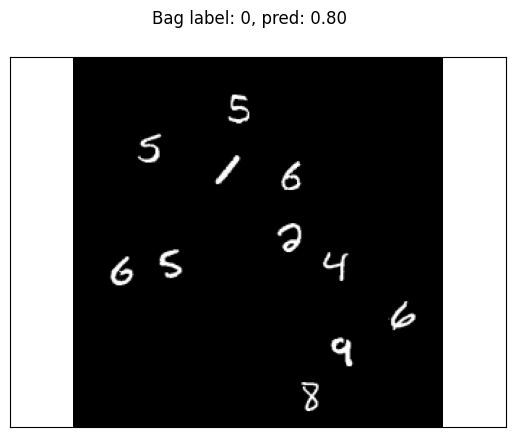

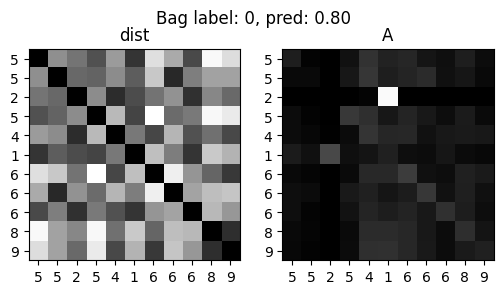

In [8]:
# Visualize first 10 mistakes
model.eval()
with torch.no_grad():
    i = 0
    for bag in test_loader:
        if i == 10:
            break
        y = bag.y.float()
        y_pred, _ = model(bag)
        if ((y_pred > .5).float() != y).cpu().detach():
            visualize_prediction(bag, y_pred)
            i += 1